Name: Sree Swiya Yarlagadda

Github Username: https://github.com/swiyasree

USC ID: 4295-5564-10

In [56]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM

(a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

In [57]:
positive_folder = "../Data/pos"
negative_folder = "../Data/neg"

(b) ii. The data are pretty clean. Remove the punctuation and numbers from the data.

In [58]:
def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    cleaned_text = re.sub(r'\d+', '', cleaned_text)  # Remove numbers
    cleaned_text = cleaned_text.replace('\n','')
    return cleaned_text.lower()  # Convert text to lowercase

def load_data_from_folder(folder_path, start_index, end_index):
    data = []
    files = os.listdir(folder_path)
    files.sort()
    for file in files[start_index: end_index + 1]:
        with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
            text = f.read()
            text = clean_text(text)
            data.append(text)
    return data

(b) iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [59]:
train_positive = load_data_from_folder(positive_folder, 0, 699)
train_negative = load_data_from_folder(negative_folder, 0, 699)
test_positive = load_data_from_folder(positive_folder, 700, 999)
test_negative = load_data_from_folder(negative_folder, 700, 999)

In [60]:
# Combine positive and negative data
train_data = train_positive + train_negative
test_data = test_positive + test_negative

# Combine train and test data
all_data = train_data + test_data

# Print size of training and testing data
print("Size of training data:", len(train_data))
print("Size of testing data:", len(test_data))

Size of training data: 1400
Size of testing data: 600


(b) i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.

In [61]:
train_labels = np.concatenate([np.ones(700), np.zeros(700)])
test_labels = np.concatenate([np.ones(300), np.zeros(300)])

(b) iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [62]:
all_dataset = set()

for data in all_data:
    data = data.replace('\n','')
    new_set = set(data.split(' '))
    all_dataset.update(new_set)
    
all_dataset.remove('')

unique_words = len(all_dataset)
print(unique_words)

47037


(b) v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [63]:
# Calculate average review length and standard deviation
train_lengths = [len(text.split()) for text in train_data]
test_lengths = [len(text.split()) for text in test_data]

average_length = np.mean(train_lengths + test_lengths)
std_dev_length = np.std(train_lengths + test_lengths)

print("Average review length:", average_length)
print("Standard deviation of review lengths:", std_dev_length)

Average review length: 644.3575
Standard deviation of review lengths: 284.98012333099655


(b) vi. Plot the histogram of review lengths.

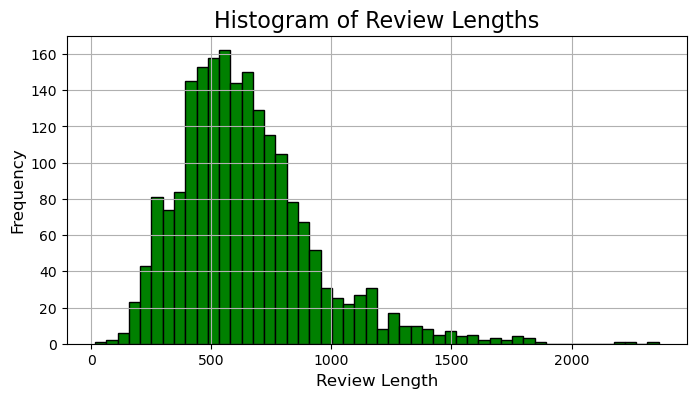

In [64]:
# Plot histogram of review lengths
plt.figure(figsize=(8, 4))  # Set figure size
plt.hist(train_lengths + test_lengths, bins=50, color='green', edgecolor='black')
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

(b) vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to rep- resent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [65]:
# Tokenization
tokenizer = Tokenizer(unique_words + 1)
tokenizer.fit_on_texts(all_data)

(b) viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%

In [66]:
# Select review length threshold
percentile = 70
L = np.percentile(train_lengths + test_lengths, percentile)
print(f"Threshold length for {percentile}% of reviews = ", L)

Threshold length for 70% of reviews =  737.0


(b) ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [67]:
# Tokenize and pad sequences
max_review_length = int(L)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

train_padded = pad_sequences(train_sequences, maxlen=max_review_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_review_length, padding='post', truncating='post')

In [68]:
print("Sample preprocessed train data: ", train_padded[:].shape)
print()
print(train_padded[:5])
print()
print("Sample preprocessed test data: ", test_padded[:].shape)
print()
print(test_padded[:5])

Sample preprocessed train data:  (1400, 737)

[[  67 2745   29 ...    0    0    0]
 [ 150  144    3 ...    0    0    0]
 [ 729  287 3642 ...    0    0    0]
 [3244    6    2 ...   66    4   13]
 [4789    6    2 ...    0    0    0]]

Sample preprocessed test data:  (600, 737)

[[ 464  103  435 ... 3277  184   25]
 [ 152 8469   30 ... 1480   55  333]
 [   1   72    7 ...    0    0    0]
 [ 729  287 3642 ...    0    0    0]
 [  11    1 2319 ...  254    3   59]]


(c) i. Assume that we are inter- ested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document.5 If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

In [69]:
# Get the indices of the top 5,000 words  
top_words_indices = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:5000]  
top_words_indices = {word: index for index, (word, _) in enumerate(top_words_indices, start=1)}

In [70]:
# Replace out-of-vocabulary words with 0  
train_padded_adjusted = [[(word if word < 5000 else 0) for word in sequence] for sequence in train_padded]  
test_padded_adjusted = [[(word if word < 5000 else 0) for word in sequence] for sequence in test_padded]

In [71]:
# Convert lists to numpy arrays  
train_padded_adjusted = np.array(train_padded_adjusted)  
test_padded_adjusted = np.array(test_padded_adjusted)

In [72]:
# Set up an embedding layer with embedding dimension of 32  
embedding_dim = 32  
embedding_layer = Embedding(input_dim=len(top_words_indices), output_dim=embedding_dim, input_length=max_review_length)

In [73]:
# Apply the embedding layer to the adjusted padded sequences  
train_embedded = embedding_layer(train_padded_adjusted)  
test_embedded = embedding_layer(test_padded_adjusted)

ii. Flatten the matrix of each document to a vector

In [74]:
# Flatten the matrix representation of each document to a vector  
train_flattened = Flatten()(train_embedded)  
test_flattened = Flatten()(test_embedded)

In [75]:
# Print shapes of flattened vectors  
print("Shape of flattened training vectors:", train_flattened.shape)  
print("Shape of flattened testing vectors:", test_flattened.shape)

Shape of flattened training vectors: (1400, 23584)
Shape of flattened testing vectors: (600, 23584)


(d) i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [151]:
# Define the MLP model
model = Sequential([
    Dense(50, activation='relu', input_shape=(23584,)),
    Dropout(0.2), 
    BatchNormalization(), 
    Dense(50, activation='relu'),
    Dropout(0.5), 
    BatchNormalization(),  
    Dense(50, activation='relu'),
    Dropout(0.5),  
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [152]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
# Train the model
history = model.fit(train_flattened, train_labels, epochs=2, batch_size=10, validation_split=0.2, verbose=1)

Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5219 - loss: 0.9046 - val_accuracy: 0.5893 - val_loss: 0.6933
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5591 - loss: 0.7935 - val_accuracy: 0.0929 - val_loss: 0.8014


In [154]:
# Evaluate the model on train and test data
train_loss, train_accuracy = model.evaluate(train_flattened, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_flattened, test_labels, verbose=0)

(d) ii. Report the train and test accuracies of this model.

In [155]:
print("MLP Model Train Accuracy:", train_accuracy)
print("MLP Model Test Accuracy:", test_accuracy)

MLP Model Train Accuracy: 0.5414285659790039
MLP Model Test Accuracy: 0.5066666603088379


(e) i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [176]:
# Define the model architecture with Conv1D layer
model_cnn = Sequential([
    Embedding(input_dim=len(top_words_indices) + 1, output_dim=embedding_dim, input_length=max_review_length),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [177]:
# Compile the model
model_cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [178]:
# Train the model
history_cnn = model_cnn.fit(train_padded_adjusted, train_labels, batch_size=10, epochs=2, validation_data=(test_padded_adjusted, test_labels))

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4941 - loss: 0.7045 - val_accuracy: 0.5400 - val_loss: 0.6924
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6168 - loss: 0.6790 - val_accuracy: 0.5433 - val_loss: 0.6869


In [179]:
# Evaluate the model on training and testing data
train_loss_cnn, train_accuracy_cnn = model_cnn.evaluate(train_padded_adjusted, train_labels, verbose=0)
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_padded_adjusted, test_labels, verbose=0)

(e) ii. Report the train and test accuracies of this model.

In [180]:
print("1D CNN Model Train accuracy:", train_accuracy_cnn)
print("1D CNN Model Test accuracy:", test_accuracy_cnn)

1D CNN Model Train accuracy: 0.8500000238418579
1D CNN Model Test accuracy: 0.5433333516120911


(f) i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [166]:
# Define the model architecture with LSTM layer
model_lstm = Sequential([
    Embedding(input_dim=len(top_words_indices) + 1, output_dim=32, input_length=max_review_length),
    LSTM(256, dropout=0.2, recurrent_dropout=0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [167]:
# Compile the model
model_lstm.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [168]:
# Train the model
history_lstm = model_lstm.fit(train_padded_adjusted, train_labels, batch_size=10, epochs=50, validation_data=(test_padded_adjusted, test_labels))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.5277 - loss: 0.6940 - val_accuracy: 0.5567 - val_loss: 0.6900
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 363ms/step - accuracy: 0.5416 - loss: 0.6892 - val_accuracy: 0.5583 - val_loss: 0.6868
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 364ms/step - accuracy: 0.5296 - loss: 0.7266 - val_accuracy: 0.5300 - val_loss: 0.6913
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 359ms/step - accuracy: 0.5214 - loss: 0.6962 - val_accuracy: 0.5400 - val_loss: 0.6874
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 341ms/step - accuracy: 0.5173 - loss: 0.7065 - val_accuracy: 0.5350 - val_loss: 0.6914
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.5265 - loss: 0.6955 - val_accuracy: 0.5333 - val_loss: 0.7019
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 360ms/step - accuracy: 0.5261 - loss: 0.6950 - val_accuracy: 0.5050 - val_loss: 0.6942
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 360ms/step - accuracy: 0.5516 - loss: 0

In [169]:
# Evaluate the model on training and testing data
train_loss_lstm, train_accuracy_lstm = model_lstm.evaluate(train_padded_adjusted, train_labels, verbose=0)
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(test_padded_adjusted, test_labels, verbose=0)

(f) ii. Report the train and test accuracies of this model.

In [170]:
print("LSTM Model Train accuracy:", train_accuracy_lstm)
print("LSTM Model Test accuracy:", test_accuracy_lstm)

LSTM Model Train accuracy: 0.9300000071525574
LSTM Model Test accuracy: 0.6083333492279053
